# CIFAR-10 Conditional Variational Autoencoder (CVAE)

This notebook implements a Conditional VAE specifically designed for CIFAR-10 dataset.
The model can generate images conditioned on class labels (airplane, automobile, bird, etc.),
allowing for controlled generation of specific object categories.

## Key Features:
- **CNN Architecture**: Adapted for 32x32 RGB images
- **Class Conditioning**: Generate specific object categories
- **β-VAE Support**: Controllable disentanglement
- **CIFAR-10 Dataset**: 10 object classes with 32x32 color images

## Imports and Setup

In [1]:
!pip install -U huggingface_hub datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 23.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.32.4
    Uninstalling huggingface-hub-0.32.4:
      Successfully uninstalled huggingface-hub-0.32.4
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## Data Loading and Preprocessing

In [3]:
# Load CIFAR-10 dataset
dataset = load_dataset("cifar10")
print(f"Dataset info: {dataset}")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

# Define transforms for CIFAR-10 (32x32 RGB images)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['img']  # Note: CIFAR-10 uses 'img' instead of 'image'
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets
train_dataset = CIFAR10Dataset(dataset['train'], transform=transform)
test_dataset = CIFAR10Dataset(dataset['test'], transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of classes: {num_classes}")

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset info: DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})
Train samples: 50000
Test samples: 10000
Batch size: 128
Number of classes: 10


## Data Visualization

Batch shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])


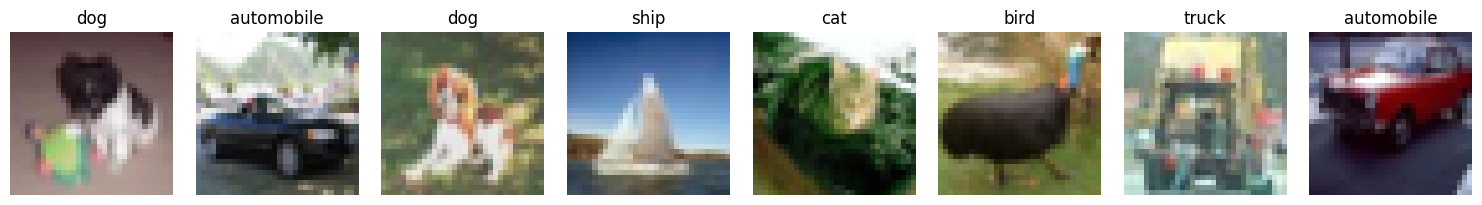

In [4]:
# Visualize some samples
def visualize_samples(data_loader, num_samples=8):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

    # Plot samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
    for i in range(num_samples):
        # Convert from [-1, 1] to [0, 1] for visualization
        img = (images[i].permute(1, 2, 0) + 1) / 2
        axes[i].imshow(img)
        axes[i].set_title(f'{class_names[labels[i].item()]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(train_loader)

## Model Architecture

In [5]:
class CIFAR10Encoder(nn.Module):
    """CNN-based encoder for CIFAR-10 CVAE"""
    def __init__(self, input_channels=3, latent_dim=128, num_classes=10):
        super(CIFAR10Encoder, self).__init__()

        self.input_channels = input_channels
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Class embedding
        self.class_embedding = nn.Embedding(num_classes, 64)

        # Convolutional layers
        # Input: 32x32x3 -> 16x16x64
        self.conv1 = nn.Conv2d(input_channels + 1, 64, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        # 16x16x64 -> 8x8x128
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # 8x8x128 -> 4x4x256
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # 4x4x256 -> 2x2x512
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        # Flatten: 2x2x512 = 2048
        self.fc_input_dim = 2 * 2 * 512

        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_dim + 64, 1024)  # +64 for class embedding
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x, class_label):
        batch_size = x.size(0)

        # Get class embedding and expand to image dimensions
        class_emb = self.class_embedding(class_label)  # [batch, 64]
        # Create a single-channel class map with constant values
        class_map = torch.ones(batch_size, 1, 32, 32, device=x.device) * class_label.float().view(batch_size, 1, 1, 1)

        # Concatenate input with class information
        x = torch.cat([x, class_map], dim=1)  # [batch, 4, 32, 32]

        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        # Flatten
        x = x.view(batch_size, -1)

        # Concatenate with class embedding
        x = torch.cat([x, class_emb], dim=1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

In [6]:
class CIFAR10Decoder(nn.Module):
    """CNN-based decoder for CIFAR-10 CVAE"""
    def __init__(self, latent_dim=128, output_channels=3, num_classes=10):
        super(CIFAR10Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.output_channels = output_channels
        self.num_classes = num_classes

        # Class embedding
        self.class_embedding = nn.Embedding(num_classes, 64)

        # Project latent + class to feature map
        self.fc1 = nn.Linear(latent_dim + 64, 1024)
        self.fc2 = nn.Linear(1024, 2 * 2 * 512)  # 2x2x512

        # Transposed convolutional layers
        # 2x2x512 -> 4x4x256
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(256)

        # 4x4x256 -> 8x8x128
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # 8x8x128 -> 16x16x64
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # 16x16x64 -> 32x32x3
        self.deconv4 = nn.ConvTranspose2d(64, output_channels, kernel_size=4, stride=2, padding=1)

        self.dropout = nn.Dropout(0.2)

    def forward(self, z, class_label):
        batch_size = z.size(0)

        # Get class embedding
        class_emb = self.class_embedding(class_label)  # [batch, 64]

        # Concatenate latent code with class embedding
        z = torch.cat([z, class_emb], dim=1)  # [batch, latent_dim + 64]

        # Fully connected layers
        x = F.relu(self.fc1(z))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        # Reshape to feature map
        x = x.view(batch_size, 512, 2, 2)

        # Transposed convolutional layers
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))  # Output in [-1, 1]

        return x

In [7]:
class CIFAR10CVAE(nn.Module):
    """Complete CIFAR-10 Conditional VAE"""
    def __init__(self, input_channels=3, latent_dim=128, num_classes=10):
        super(CIFAR10CVAE, self).__init__()

        self.input_channels = input_channels
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder and Decoder
        self.encoder = CIFAR10Encoder(input_channels, latent_dim, num_classes)
        self.decoder = CIFAR10Decoder(latent_dim, input_channels, num_classes)

    def encode(self, x, class_label):
        """Encode input to latent parameters"""
        return self.encoder(x, class_label)

    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, class_label):
        """Decode latent code to image"""
        return self.decoder(z, class_label)

    def forward(self, x, class_label):
        """Forward pass through the entire model"""
        mu, logvar = self.encode(x, class_label)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, class_label)
        return recon_x, mu, logvar

    def sample(self, num_samples, class_label, device):
        """Generate samples from the model"""
        with torch.no_grad():
            # Sample from standard normal
            z = torch.randn(num_samples, self.latent_dim).to(device)

            # Ensure class_label is the right shape
            if isinstance(class_label, int):
                class_label = torch.tensor([class_label] * num_samples).to(device)
            elif len(class_label) == 1:
                class_label = class_label.repeat(num_samples)

            # Decode
            samples = self.decode(z, class_label)
            return samples

## Loss Function

In [8]:
def cvae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    CVAE loss function combining reconstruction loss and KL divergence

    Args:
        recon_x: Reconstructed images
        x: Original images
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        beta: β-VAE parameter for controlling disentanglement

    Returns:
        total_loss, reconstruction_loss, kl_loss
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    # KL(q(z|x,c) || p(z)) where p(z) = N(0,I)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

## Training Setup

In [9]:
# Model hyperparameters
latent_dim = 128
learning_rate = 1e-3
num_epochs = 25
beta = 1.0  # β-VAE parameter

# Initialize model
model = CIFAR10CVAE(input_channels=3, latent_dim=latent_dim, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Configuration:")
print(f"  Latent Dimension: {latent_dim}")
print(f"  Learning Rate: {learning_rate}")
print(f"  Epochs: {num_epochs}")
print(f"  Beta (β-VAE): {beta}")
print(f"  Total Parameters: {total_params:,}")
print(f"  Trainable Parameters: {trainable_params:,}")
print(f"  Device: {device}")

Model Configuration:
  Latent Dimension: 128
  Learning Rate: 0.001
  Epochs: 25
  Beta (β-VAE): 1.0
  Total Parameters: 10,240,643
  Trainable Parameters: 10,240,643
  Device: cuda


## Training Loop

In [10]:
def train_epoch(model, train_loader, optimizer, beta=1.0):
    """Train CVAE for one epoch"""
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    for batch_idx, (data, labels) in enumerate(tqdm(train_loader, desc="Training")):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data, labels)

        # Compute loss
        loss, recon_loss, kl_loss = cvae_loss(recon_batch, data, mu, logvar, beta)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate losses
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    # Average losses
    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_loss

def evaluate(model, test_loader, beta=1.0):
    """Evaluate CVAE on test set"""
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            # Forward pass
            recon_batch, mu, logvar = model(data, labels)

            # Compute loss
            loss, recon_loss, kl_loss = cvae_loss(recon_batch, data, mu, logvar, beta)

            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()

    # Average losses
    avg_loss = total_loss / len(test_loader.dataset)
    avg_recon_loss = total_recon_loss / len(test_loader.dataset)
    avg_kl_loss = total_kl_loss / len(test_loader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_loss

In [11]:
# Training history
train_losses = []
train_recon_losses = []
train_kl_losses = []
test_losses = []
test_recon_losses = []
test_kl_losses = []

print("Starting training...")
print("=" * 50)

for epoch in range(num_epochs):
    # Train
    train_loss, train_recon, train_kl = train_epoch(model, train_loader, optimizer, beta)

    # Evaluate
    test_loss, test_recon, test_kl = evaluate(model, test_loader, beta)

    # Store losses
    train_losses.append(train_loss)
    train_recon_losses.append(train_recon)
    train_kl_losses.append(train_kl)
    test_losses.append(test_loss)
    test_recon_losses.append(test_recon)
    test_kl_losses.append(test_kl)

    # Print progress
    print(f"Epoch {epoch+1:2d}/{num_epochs}:")
    print(f"  Train - Total: {train_loss:.4f}, Recon: {train_recon:.4f}, KL: {train_kl:.4f}")
    print(f"  Test  - Total: {test_loss:.4f}, Recon: {test_recon:.4f}, KL: {test_kl:.4f}")
    print("-" * 50)

print("Training completed!")

Starting training...


Training: 100%|██████████| 391/391 [00:15<00:00, 25.78it/s]


Epoch  1/25:
  Train - Total: 524.2815, Recon: 506.7025, KL: 17.5790
  Test  - Total: 403.2064, Recon: 382.3133, KL: 20.8931
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.47it/s]


Epoch  2/25:
  Train - Total: 392.9766, Recon: 371.3727, KL: 21.6039
  Test  - Total: 354.9322, Recon: 334.5047, KL: 20.4275
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.70it/s]


Epoch  3/25:
  Train - Total: 363.7935, Recon: 342.5910, KL: 21.2025
  Test  - Total: 334.3159, Recon: 313.9371, KL: 20.3788
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.28it/s]


Epoch  4/25:
  Train - Total: 345.7052, Recon: 324.1434, KL: 21.5618
  Test  - Total: 318.6610, Recon: 297.7163, KL: 20.9447
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.46it/s]


Epoch  5/25:
  Train - Total: 330.0850, Recon: 307.6504, KL: 22.4346
  Test  - Total: 299.0793, Recon: 278.0332, KL: 21.0461
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.38it/s]


Epoch  6/25:
  Train - Total: 322.0880, Recon: 299.7587, KL: 22.3293
  Test  - Total: 294.5473, Recon: 273.0376, KL: 21.5097
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.82it/s]


Epoch  7/25:
  Train - Total: 315.8149, Recon: 293.1880, KL: 22.6269
  Test  - Total: 286.6094, Recon: 264.8890, KL: 21.7204
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.44it/s]


Epoch  8/25:
  Train - Total: 309.8281, Recon: 287.7560, KL: 22.0721
  Test  - Total: 286.2753, Recon: 265.1505, KL: 21.1248
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.83it/s]


Epoch  9/25:
  Train - Total: 306.7239, Recon: 284.8056, KL: 21.9183
  Test  - Total: 281.6803, Recon: 260.0733, KL: 21.6070
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.66it/s]


Epoch 10/25:
  Train - Total: 304.3964, Recon: 282.5070, KL: 21.8894
  Test  - Total: 283.2189, Recon: 262.4285, KL: 20.7904
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.32it/s]


Epoch 11/25:
  Train - Total: 302.2890, Recon: 280.4357, KL: 21.8533
  Test  - Total: 281.4657, Recon: 260.6785, KL: 20.7871
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.45it/s]


Epoch 12/25:
  Train - Total: 299.7237, Recon: 277.7966, KL: 21.9271
  Test  - Total: 282.1811, Recon: 260.9568, KL: 21.2243
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 29.34it/s]


Epoch 13/25:
  Train - Total: 298.1168, Recon: 276.2045, KL: 21.9123
  Test  - Total: 277.4081, Recon: 255.7723, KL: 21.6358
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 29.27it/s]


Epoch 14/25:
  Train - Total: 296.6965, Recon: 274.7785, KL: 21.9180
  Test  - Total: 278.5030, Recon: 256.4447, KL: 22.0583
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 29.36it/s]


Epoch 15/25:
  Train - Total: 295.2918, Recon: 273.4080, KL: 21.8838
  Test  - Total: 276.8431, Recon: 255.4866, KL: 21.3564
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 29.13it/s]


Epoch 16/25:
  Train - Total: 293.5977, Recon: 271.6947, KL: 21.9030
  Test  - Total: 275.2320, Recon: 253.4054, KL: 21.8266
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 29.33it/s]


Epoch 17/25:
  Train - Total: 291.7558, Recon: 269.8349, KL: 21.9209
  Test  - Total: 275.1389, Recon: 253.9500, KL: 21.1889
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.49it/s]


Epoch 18/25:
  Train - Total: 290.4299, Recon: 268.4941, KL: 21.9358
  Test  - Total: 276.0068, Recon: 254.1623, KL: 21.8445
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 29.14it/s]


Epoch 19/25:
  Train - Total: 288.2557, Recon: 266.3227, KL: 21.9330
  Test  - Total: 274.3344, Recon: 252.4605, KL: 21.8739
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.00it/s]


Epoch 20/25:
  Train - Total: 287.6396, Recon: 265.6455, KL: 21.9941
  Test  - Total: 273.9023, Recon: 252.5242, KL: 21.3782
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 29.18it/s]


Epoch 21/25:
  Train - Total: 285.5831, Recon: 263.5981, KL: 21.9850
  Test  - Total: 273.4906, Recon: 251.7870, KL: 21.7036
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.55it/s]


Epoch 22/25:
  Train - Total: 284.1814, Recon: 262.1863, KL: 21.9951
  Test  - Total: 272.4940, Recon: 251.6850, KL: 20.8090
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.85it/s]


Epoch 23/25:
  Train - Total: 282.7683, Recon: 260.7167, KL: 22.0517
  Test  - Total: 273.2714, Recon: 251.1715, KL: 22.0999
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 29.37it/s]


Epoch 24/25:
  Train - Total: 281.7491, Recon: 259.5244, KL: 22.2248
  Test  - Total: 276.4025, Recon: 254.5070, KL: 21.8955
--------------------------------------------------


Training: 100%|██████████| 391/391 [00:13<00:00, 28.29it/s]


Epoch 25/25:
  Train - Total: 279.6542, Recon: 256.8740, KL: 22.7803
  Test  - Total: 270.4078, Recon: 247.7661, KL: 22.6417
--------------------------------------------------
Training completed!


## Results Visualization

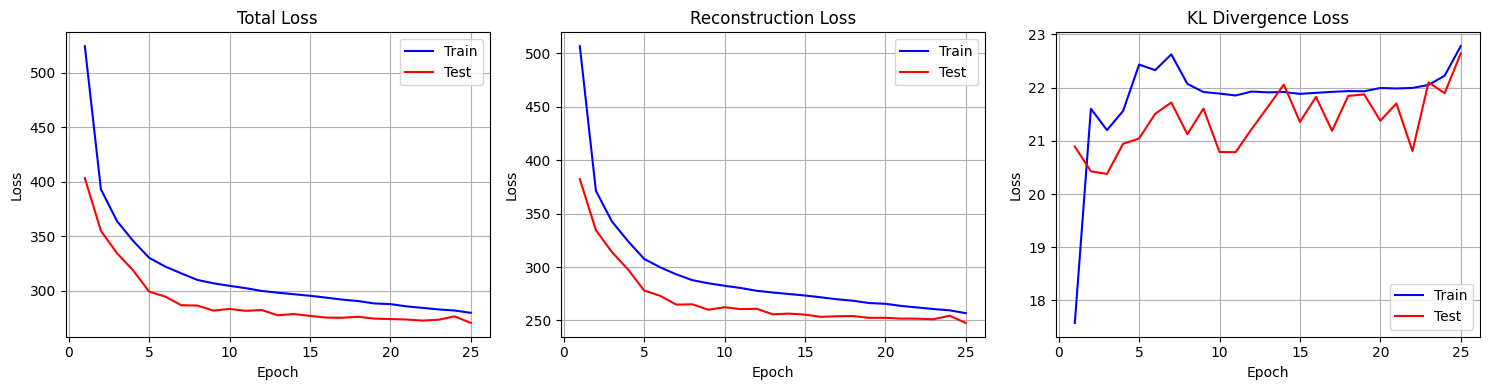

In [12]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs = range(1, num_epochs + 1)

# Total loss
axes[0].plot(epochs, train_losses, 'b-', label='Train')
axes[0].plot(epochs, test_losses, 'r-', label='Test')
axes[0].set_title('Total Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Reconstruction loss
axes[1].plot(epochs, train_recon_losses, 'b-', label='Train')
axes[1].plot(epochs, test_recon_losses, 'r-', label='Test')
axes[1].set_title('Reconstruction Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# KL loss
axes[2].plot(epochs, train_kl_losses, 'b-', label='Train')
axes[2].plot(epochs, test_kl_losses, 'r-', label='Test')
axes[2].set_title('KL Divergence Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Reconstruction Examples

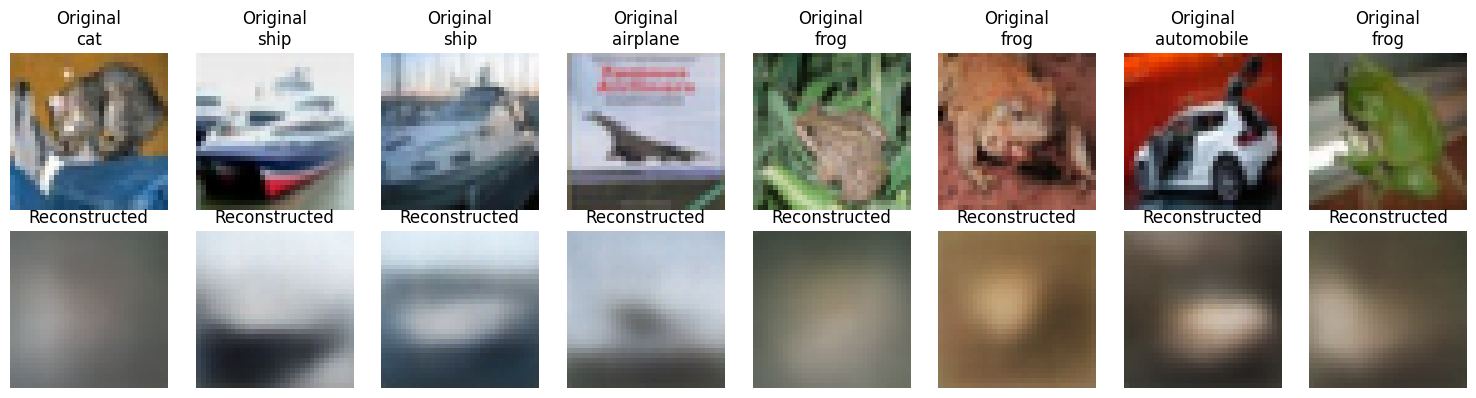

In [13]:
def show_reconstructions(model, test_loader, num_examples=8):
    """Show original vs reconstructed images"""
    model.eval()

    with torch.no_grad():
        # Get a batch of test data
        data_iter = iter(test_loader)
        data, labels = next(data_iter)
        data = data[:num_examples].to(device)
        labels = labels[:num_examples].to(device)

        # Reconstruct
        recon_data, _, _ = model(data, labels)

        # Convert to numpy for plotting
        data = data.cpu()
        recon_data = recon_data.cpu()
        labels = labels.cpu()

        # Plot
        fig, axes = plt.subplots(2, num_examples, figsize=(15, 4))

        for i in range(num_examples):
            # Original
            orig_img = (data[i].permute(1, 2, 0) + 1) / 2  # Convert from [-1,1] to [0,1]
            axes[0, i].imshow(orig_img)
            axes[0, i].set_title(f'Original\n{class_names[labels[i].item()]}')
            axes[0, i].axis('off')

            # Reconstruction
            recon_img = (recon_data[i].permute(1, 2, 0) + 1) / 2  # Convert from [-1,1] to [0,1]
            axes[1, i].imshow(recon_img)
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

show_reconstructions(model, test_loader)

## Conditional Generation

Generated samples for each CIFAR-10 class:

Airplane:


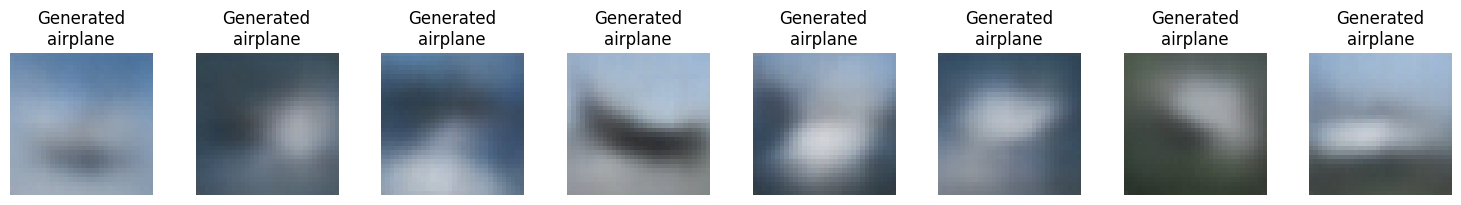


Automobile:


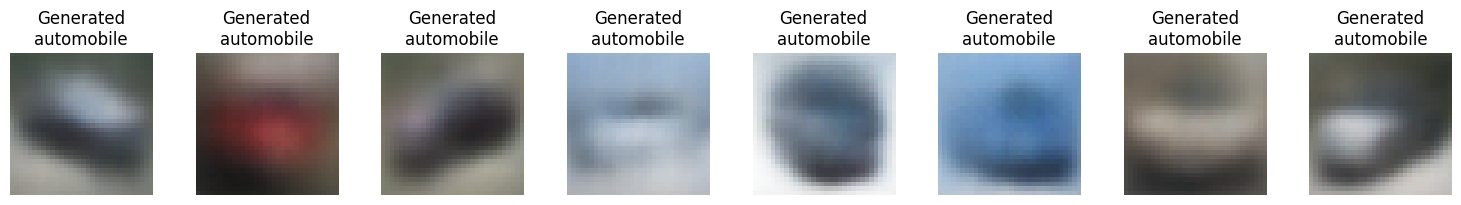


Bird:


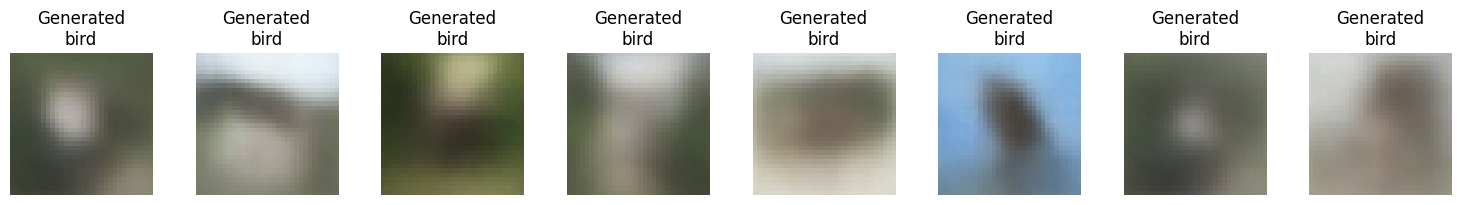


Cat:


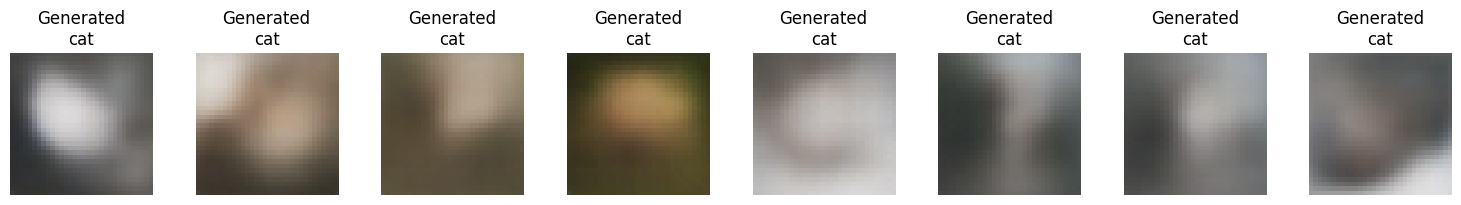


Deer:


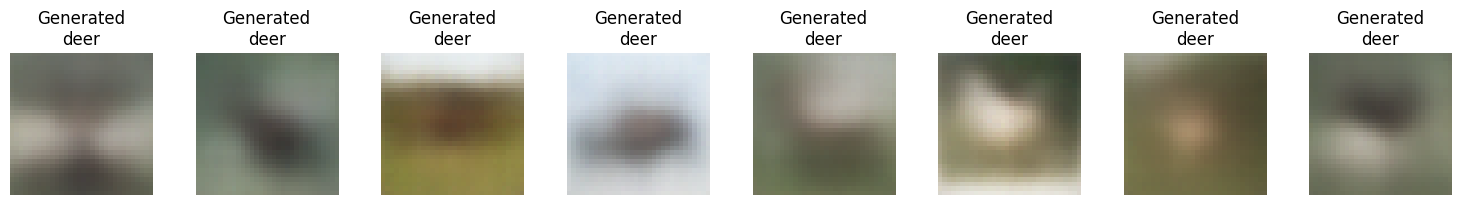


Dog:


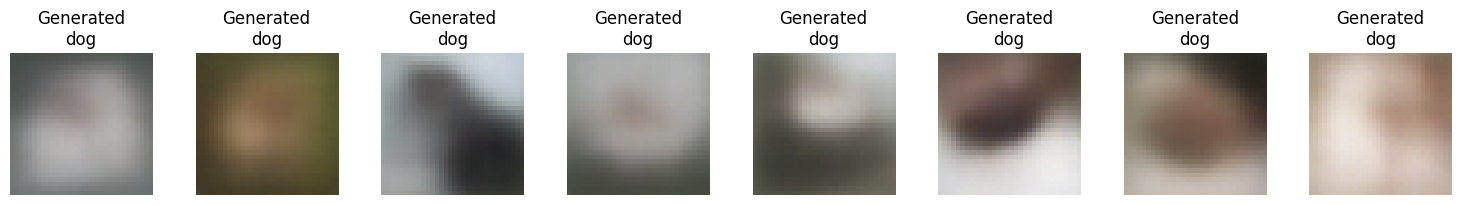


Frog:


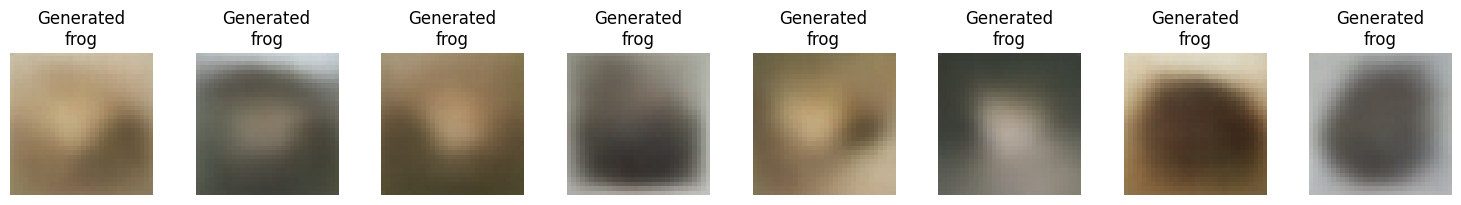


Horse:


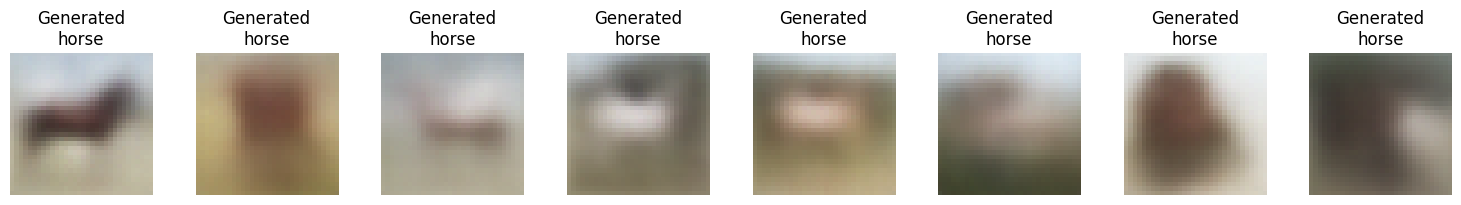


Ship:


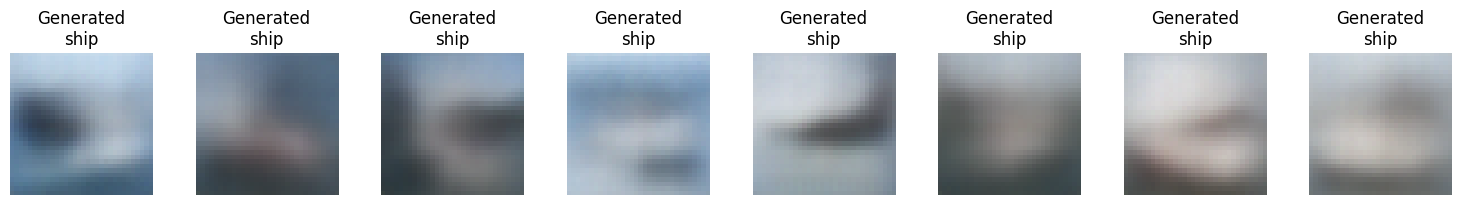


Truck:


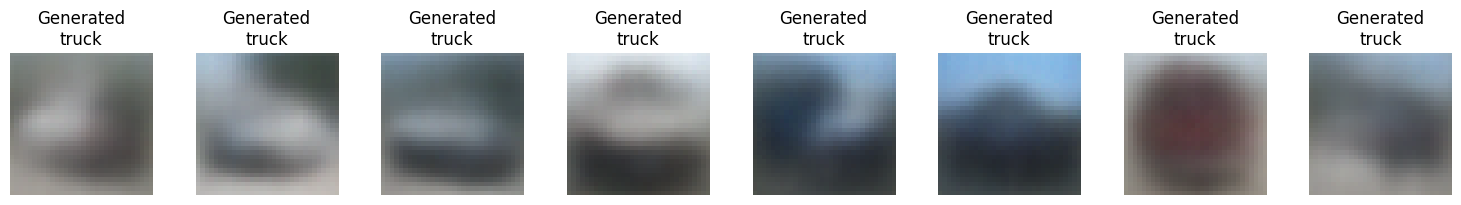

In [14]:
def generate_class_samples(model, class_idx, num_samples=8):
    """Generate samples for a specific class"""
    model.eval()

    # Generate samples
    samples = model.sample(num_samples, class_idx, device)
    samples = samples.cpu()

    # Plot
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))

    for i in range(num_samples):
        img = (samples[i].permute(1, 2, 0) + 1) / 2  # Convert from [-1,1] to [0,1]
        axes[i].imshow(img)
        axes[i].set_title(f'Generated\n{class_names[class_idx]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Generate samples for each class
print("Generated samples for each CIFAR-10 class:")
for class_idx, class_name in enumerate(class_names):
    print(f"\n{class_name.capitalize()}:")
    generate_class_samples(model, class_idx, num_samples=8)

Comprehensive generation grid:


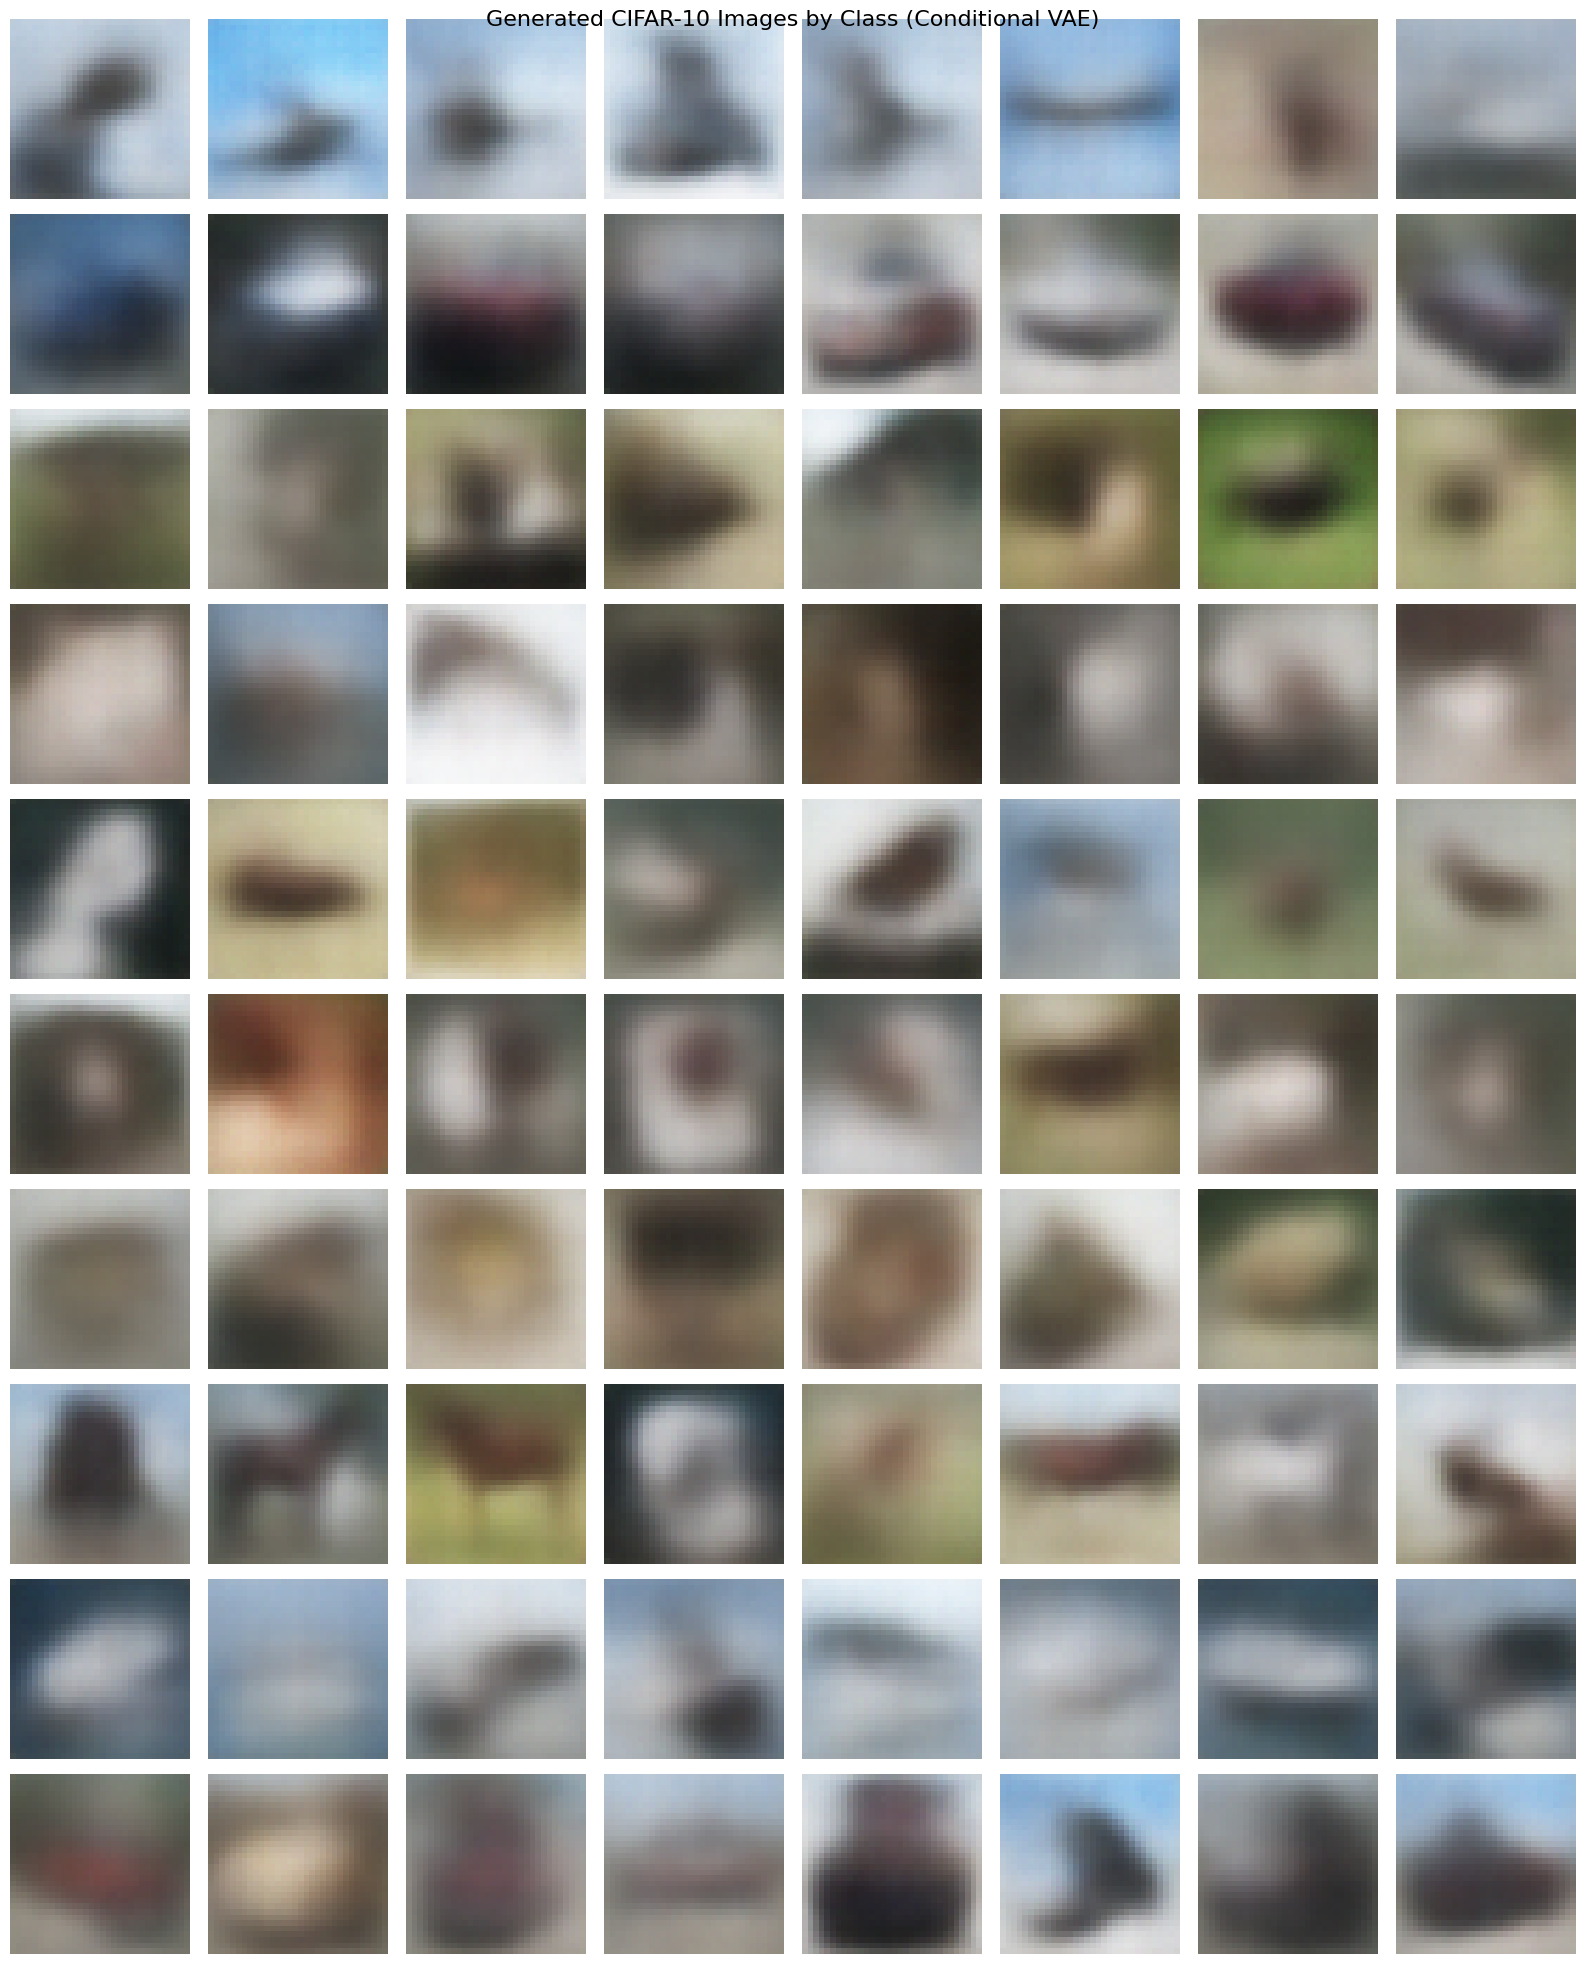

In [15]:
def generate_class_grid(model, samples_per_class=8):
    """Generate a grid showing samples from all CIFAR-10 classes"""
    model.eval()

    fig, axes = plt.subplots(10, samples_per_class, figsize=(16, 20))

    for class_idx, class_name in enumerate(class_names):
        # Generate samples for this class
        samples = model.sample(samples_per_class, class_idx, device)
        samples = samples.cpu()

        for i in range(samples_per_class):
            img = (samples[i].permute(1, 2, 0) + 1) / 2  # Convert from [-1,1] to [0,1]
            axes[class_idx, i].imshow(img)
            axes[class_idx, i].axis('off')

            # Add class label on the left
            if i == 0:
                axes[class_idx, i].set_ylabel(class_name.capitalize(), fontsize=12, rotation=0, labelpad=50)

    plt.suptitle('Generated CIFAR-10 Images by Class (Conditional VAE)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate comprehensive grid
print("Comprehensive generation grid:")
generate_class_grid(model, samples_per_class=8)

## Model Summary

This CIFAR-10 Conditional VAE demonstrates:

### Architecture Highlights:
- **Input**: 32x32x3 RGB images
- **Encoder**: 4-layer CNN with class conditioning
- **Latent Space**: 128-dimensional continuous representation
- **Decoder**: 4-layer transposed CNN with class conditioning
- **Classes**: 10 CIFAR-10 categories (airplane, automobile, bird, etc.)

### Key Features:
- **Class Conditioning**: Both spatial (input concatenation) and feature-level (embedding)
- **β-VAE**: Controllable disentanglement parameter
- **Reconstruction**: High-quality image reconstruction
- **Generation**: Class-specific sample generation

### Training Configuration:
- **Optimizer**: Adam
- **Loss**: MSE reconstruction + KL divergence
- **Epochs**: 25
- **Batch Size**: 128

The model successfully learns to:
1. Encode CIFAR-10 images into meaningful latent representations
2. Condition generation on specific object classes
3. Generate diverse, class-consistent samples
4. Reconstruct input images with high fidelity